In [67]:
from collections import defaultdict
from tqdm import tqdm

import numpy as np
import math
import statistics as stat
import random

from matchings import cross_bin_matching, same_bin_matching, immediate_neighbor_matching, max_weight_matching
from scipy.stats import norm

import matplotlib.pyplot as plt
import matplotlib.patches as patches

lblue  = (40/255,103/255,178/255)
sgreen = (46/255,139/255,87/255)
cred   = (177/255,4/255,14/255)


plt.rcParams.update({
    'lines.linewidth' : 1.,
    'lines.markersize' : 5,
    'font.size': 9,
    "text.usetex": True,
    'font.family': 'serif', 
    'font.serif': ['Computer Modern'],
    'text.latex.preamble' : r'\usepackage{amsmath,amsfonts}',
    'axes.linewidth' : .75})

In [68]:
def SCINT_test(X, Y, M, nperm=500):
    Del_X = np.array([X[i]-X[j] for (i,j) in M])
    Del_Y = np.array([Y[i]-Y[j] for (i,j) in M])
    
    D_S = np.einsum('ij, j, j -> i', 
                    (np.random.rand(nperm, len(M)) < .5), 
                    Del_X, 
                    Del_Y)
    
    return (1+np.sum(D_S <= 0))/(1+nperm)

In [70]:
def mu(Y,Z,beta):
    return (Z + beta * Y)

def sim_YZ(n, setting):
    if setting == 1:
        Z = np.random.normal(0,1,n)
        Y = np.random.normal(0,1,n)
        
    elif setting == 2:
        Z = np.random.normal(0,1,n)
        Y = Z + np.random.normal(0,1,n)
        
    elif setting == 3:
        Z = np.random.normal(0,1,n)
        Y = -Z + np.random.normal(0,1,n)
        
    return Y, Z

# Power analysis

In [94]:
nseq=2**np.arange(9, 15)

In [93]:
%%time
nrep=1000; alpha=0.1 # 50

def power_analysis_sim(setting):
    pvalues = defaultdict(lambda : defaultdict(lambda : np.zeros(nrep)))
    power   = defaultdict(lambda : defaultdict(float))
    for n in tqdm(nseq):
        eta = 1/(n**0.75)

        
        for l in range(nrep):
            Y,Z = sim_YZ(n, setting)

            matchings = {}
            matchings['nbhd'] = immediate_neighbor_matching(Y, Z)
            matchings['sb']   = same_bin_matching(Y, Z, eta)
            matchings['cb']   = cross_bin_matching(Y, Z, eta)
            
            for beta, level in [(2/n, 'below'), (2/np.sqrt(n), 'at'), (1/(n**0.42), 'above')]: 
                X = mu(Y,Z,beta) + np.random.normal(0,1,n)
                for label, M in matchings.items():
                    pvalues[(level, label)][n][l] = SCINT_test(X,Y,M)
        for k in pvalues:
            power[k][n] = np.mean(pvalues[k][n] < alpha)
    return(pvalues, power)

power_results = []
_, power1 = power_analysis_sim(1)
power_results.append(power1)

_, power2 = power_analysis_sim(2)
power_results.append(power2)

_, power3 = power_analysis_sim(3)
power_results.append(power3)

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [07:03<00:00, 70.56s/it]

CPU times: user 21min 9s, sys: 52.4 s, total: 22min 1s
Wall time: 22min 5s


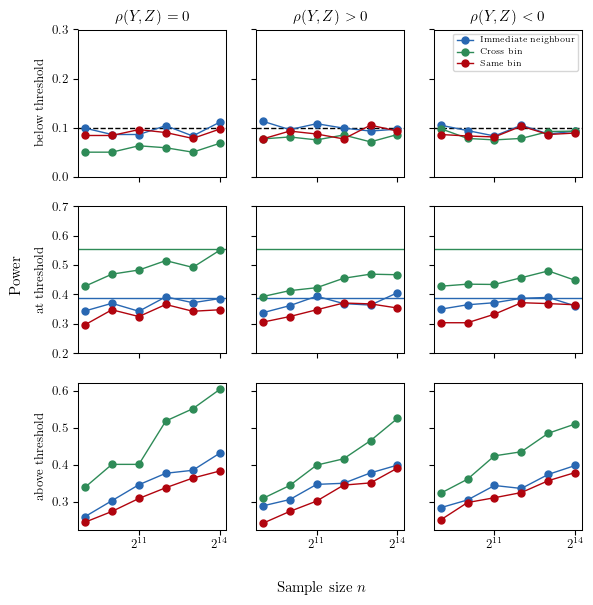

In [128]:
from matplotlib.transforms import offset_copy

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(6.5, 6.5), # 4.875
                         sharex=True, sharey='row')

col_titles = [r'$\rho (Y,Z)$ {}'.format(col) for col in ['$=0$','$>0$','$<0$']]

levels = ['below', 'at', 'above']
row_titles = ['{} threshold'.format(row) for row in levels]


methods = [('nbhd', "Immediate neighbour", lblue), 
           ('cb', "Cross bin", sgreen), 
           ('sb', "Same bin", cred), ]

for col in range(3):
    axes[0,col].axhline(y=alpha,c=(0,0,0),linestyle='--')
    axes[0,col].set_title(col_titles[col])
    axes[1,col].axhline(y=norm.cdf(1-norm.ppf(1-alpha)),c=lblue)
    axes[1,col].axhline(y=norm.cdf(np.sqrt(2)-norm.ppf(1-alpha)),c=sgreen)
    

    for row, level in enumerate(levels):
        for nm, name, color in methods:
            axes[row,col].plot(nseq, power_results[col][(level,nm)].values(), marker='o', 
                               linestyle='solid', c=color, label=name)

for row, title in enumerate(row_titles):
    axes[row, 0].set_ylabel(title)
            
axes[0,0].set_ylim(0,0.3)
axes[1,0].set_ylim(0.2,0.7)

lines = [] 
labels = [] 
Line, Label = axes[0,0].get_legend_handles_labels() 
lines.extend(Line) 
labels.extend(Label) 

axes[0,0].set_xscale('log', base=2)
fig.supxlabel('Sample size $n$')
fig.supylabel('Power')
# fig.legend(lines, labels, loc='right')
axes[0,2].legend(fontsize=6)
fig.savefig('figures/power_curve_log_tall.png')
plt.show()

# Type I Error analysis

In [130]:
%%time
nrep=1000 # 50

def effect_on_validity():
    pvalues = defaultdict(lambda : defaultdict(lambda : np.zeros(nrep)))

    for n in tqdm(nseq):
        eta = 1/(n**0.75)

        
        for l in range(nrep):
            Z = np.random.normal(0,1,n)
            Y = np.random.normal(0,1,n)
            eta = 1/(n**0.75)

            matchings = {}
            matchings['nbhd'] = immediate_neighbor_matching(Y, Z)
            matchings['sb']   = same_bin_matching(Y, Z, eta)
            matchings['cb']   = cross_bin_matching(Y, Z, eta)
            
            for setting in range(3):
                if setting==0:
                    mu=Z
                elif setting==1:
                    mu=norm.cdf(Z)
                elif setting==2:
                    mu=10*Z
                X = mu + np.random.normal(0,1,n)
                for label, M in matchings.items():
                    pvalues[(setting, label)][n][l] = SCINT_test(X,Y,M)
    return(pvalues)

results = effect_on_validity()

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [07:59<00:00, 79.87s/it]

CPU times: user 7min 37s, sys: 20.6 s, total: 7min 57s
Wall time: 7min 59s


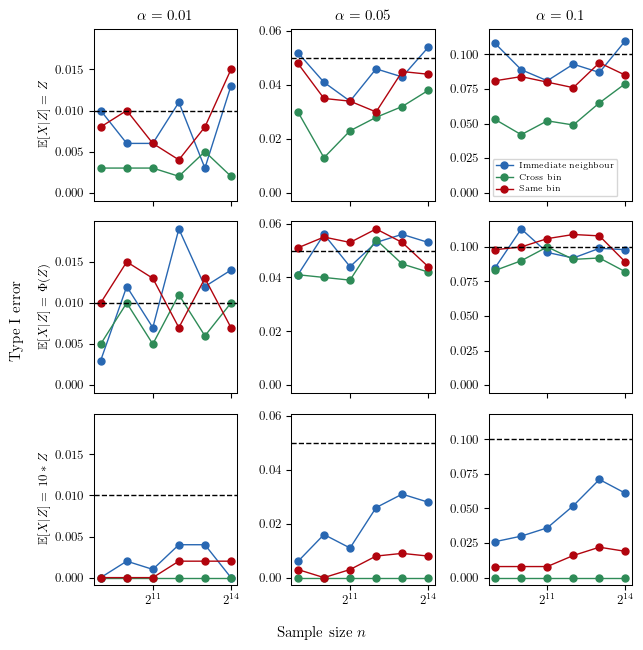

In [161]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(6.5, 6.5), # 4.875
                         sharex=True, sharey='col')

alphas = [.01, .05, .1]
col_titles = [r'$\alpha=$ {}'.format(col) for col in ['$0.01$','$0.05$','$0.1$']]
row_titles = [r'$\mathbb E[X|Z]=$ {}'.format(row) for row in ['$Z$', '$\Phi(Z)$', '$10*Z$']]

methods = [('nbhd', "Immediate neighbour", lblue), 
           ('cb', "Cross bin", sgreen), 
           ('sb', "Same bin", cred), ]

for col in range(3):
    axes[0,col].set_title(col_titles[col])
#     axes[1,col].axhline(y=norm.cdf(1-norm.ppf(1-alpha)),c=lblue)
#     axes[1,col].axhline(y=norm.cdf(np.sqrt(2)-norm.ppf(1-alpha)),c=sgreen)
    
    alpha = alphas[col]
    for row, title in enumerate(row_titles):
        for nm, name, color in methods:
            axes[row,col].plot(nseq, [np.mean(results[(row,nm)][n] < alpha) for n in nseq], marker='o', 
                               linestyle='solid', c=color, label=name)
        axes[row,col].axhline(y=alpha,c=(0,0,0),linestyle='--')

for row, title in enumerate(row_titles):
    axes[row, 0].set_ylabel(title)
            
# axes[0,0].set_ylim(0,0.3)
# axes[1,0].set_ylim(0.2,0.7)

# axes[0,0].set_yticks([0, .01, .02], ['0', '.01', 'c'])

# fig.subplots_adjust(1)

lines = [] 
labels = [] 
Line, Label = axes[0,0].get_legend_handles_labels() 
lines.extend(Line) 
labels.extend(Label) 

axes[0,0].set_xscale('log', base=2)
fig.supxlabel('Sample size $n$')
fig.supylabel('Type I error')
# fig.legend(lines, labels, loc='right')
axes[0,2].legend(fontsize=6)
plt.tight_layout()
fig.savefig('figures/validity_curve_log_tall.png')
plt.show()